In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import fmin_cg

In [2]:
dataset = loadmat('ex4data1.mat')
features = dataset.get('X')
labels = dataset.get('y').flatten()
print(features.shape)
print(labels.shape)

(5000, 400)
(5000,)


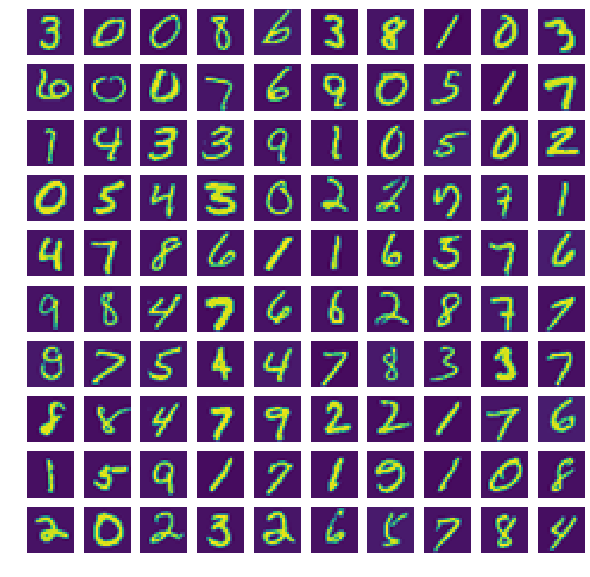

In [3]:
# visualizing the data
_, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(features[np.random.randint(features.shape[0])].reshape((20,20), order = 'F'))          
        axarr[i,j].axis('off')

In [4]:
weights = loadmat('ex4weights.mat')
theta1 = weights.get('Theta1').T
theta2 = weights.get('Theta2').T
print(theta1.shape)
print(theta2.shape)

(401, 25)
(26, 10)


In [5]:
input_layer_size = features.shape[1]
hidden_layer_size = theta1.shape[1]
num_labels = theta2.shape[1]
lamda = 1

In [6]:
def unroll_params(t1, t2):
    return np.hstack((t1.ravel(order='F'), t2.ravel(order='F')))

def roll_params(t):
    t1 = np.reshape(t[:hidden_layer_size * (input_layer_size+1)], (input_layer_size+1, hidden_layer_size), 'F')
    t2 = np.reshape(t[hidden_layer_size * (input_layer_size+1):], (hidden_layer_size+1, num_labels), 'F')
    return t1,t2

thetas = unroll_params(theta1, theta2)
print(thetas.shape)

(10285,)


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    g = sigmoid(z)
    return g * (1 - g)

In [8]:
def neural_net_cost_function(t, x, y, lamd):
    t1, t2 = roll_params(t)
    m = y.shape[0]
    ones = np.ones((m, 1))
    a1 = np.hstack((ones, x))
    z2 = np.dot(a1, t1)
    a2 = sigmoid(z2)
    a2 = np.hstack((ones, a2))
    z3 = np.dot(a2, t2)
    h = sigmoid(z3)
    
    y_d = pd.get_dummies(y).values
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(t1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(t2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lamd / (2*m)
    
neural_net_cost_function(thetas, features, labels, lamda)

0.37904640005669177

In [9]:
def random_init_weights(L_in, L_out):
    epsilon = (6 ** 1/2) / ((L_in + L_out) ** 1/2)
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

initial_theta1 = random_init_weights(input_layer_size, hidden_layer_size)
initial_theta2 = random_init_weights(hidden_layer_size, num_labels)

# unrolling parameters into a single column vector
initial_thetas = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

In [10]:
def neural_net_gradient(t, x, y, lamd):
    init_theta1 = np.reshape(t[:hidden_layer_size * (input_layer_size+1)], (input_layer_size+1, hidden_layer_size), 'F')
    init_theta2 = np.reshape(t[hidden_layer_size * (input_layer_size+1):], (hidden_layer_size+1, num_labels), 'F')
    y_d = pd.get_dummies(y).values
    delta1 = np.zeros(init_theta1.shape)
    delta2 = np.zeros(init_theta2.shape)
    m = y.shape[0]
    
    for i in range(x.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, x[i]))
        z2 = np.dot(a1, init_theta1)
        a2 = sigmoid(z2)
        a2 = np.hstack((ones, a2))
        z3 = np.dot(a2, init_theta2)
        a3 = sigmoid(z3)
        
        d3 = a3 - y_d[i,:]
        z2 = np.hstack((ones, z2))
        d2 = np.dot(init_theta2, d3) * sigmoid_derivative(z2)
        
        d2 = d2[1:, np.newaxis,]
    
        d3 = d3[:, np.newaxis]
        
        a2 = a2[:, np.newaxis]
        
        a1 = a1[:, np.newaxis]
        
        delta1 += np.dot(a1, d2.T)
        delta2 += np.dot(a2, d3.T)
        
    
    delta1 /= m
    delta2 /= m
    
    delta1[1:] += (lamd / m) * init_theta1[1:]
    delta2[1:] += (lamd / m) * init_theta2[1:]
    
    return unroll_params(delta1, delta2)
        
        
weights = neural_net_gradient(thetas, features, labels, lamda)

In [12]:
def train_neural_net(x, y):
    lamd = 1
    thetas = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))
    thetas = fmin_cg(maxiter = 50, f = neural_net_cost_function, x0 = thetas, fprime = neural_net_gradient, args = (x, y.flatten(), lamd))
    return thetas
    
optimized_weights = train_neural_net(features, labels)

         Current function value: 0.491259
         Iterations: 50
         Function evaluations: 116
         Gradient evaluations: 116


In [13]:
print(optimized_weights.shape)

(10285,)


In [17]:
def predict(theta1, theta2, x):
    m = x.shape[0]
    ones = np.ones((m,1))
    a1 = np.hstack((ones, x))
    z2 = np.dot(a1, theta1)
    a2 = sigmoid(z2)
    a2 = np.hstack((ones, a2))
    z3 = np.dot(a2, theta2)
    h = sigmoid(z3)
    
    return np.argmax(h, axis = 1) + 1
    
theta1_opt, theta2_opt = roll_params(optimized_weights)
pred = predict(theta1_opt, theta2_opt, features)
print("Accuracy : ", np.mean(pred == labels.flatten()) * 100)


Accuracy :  95.89999999999999
